In [1]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [2]:
autism_tweets_df = pd.read_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/austim_tweets_with_sentiment-all.csv')
control_tweets_df = pd.read_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/control_tweets_with_sentiment-all.csv')


print(autism_tweets_df.head())
print(control_tweets_df.head())
print(autism_tweets_df.isnull().sum())
print(control_tweets_df.isnull().sum())

                                             User_ID  Friends count  \
0  4d40ced1122d03ff51565e460723aa88cf10da83a47872...            152   
1  60f8e994a389fc65557cdf594582e5764fab50766cd13b...           1756   
2  975f72be21fc87c6701385533e6e25c789a84e0f4074b8...           1278   
3  a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...            771   
4  60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...           3692   

   Followers count                 Tweet date             Tweet id  \
0              361  2022-12-31 23:01:30+00:00  1609323893193318401   
1             2868  2022-12-31 21:42:00+00:00  1609303887030243330   
2              280  2022-12-31 20:20:12+00:00  1609283300857909250   
3              752  2022-12-31 20:15:30+00:00  1609282116965257219   
4             1733  2022-12-31 20:13:32+00:00  1609281620657467398   

                                          Tweet text  \
0  hi , 'm xironium , actuallyautistic gamer/stre...   
1  happynewyear friend ! 🥂 grateful wond

### Hashtags detailed info

In [3]:
# Replace NaN values in the 'Hashtags' column with empty lists
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].fillna('[]')
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].fillna('[]')

# Convert the 'Hashtags' column strings to lists
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].apply(ast.literal_eval)
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].apply(ast.literal_eval)

# Flatten the lists of hashtags and count the frequencies for each dataset
control_hashtags = [hashtag for sublist in control_tweets_df['Hashtags'] for hashtag in sublist]
autism_hashtags = [hashtag for sublist in autism_tweets_df['Hashtags'] for hashtag in sublist]

control_hashtag_freq = Counter(control_hashtags)
autism_hashtag_freq = Counter(autism_hashtags)

# Convert Counter objects to DataFrames
control_hashtag_df = pd.DataFrame(control_hashtag_freq.items(), columns=[ 'Hashtag', 'Count']).sort_values(by='Count', ascending=False)
autism_hashtag_df = pd.DataFrame(autism_hashtag_freq.items(), columns=[ 'Hashtag', 'Count']).sort_values(by='Count', ascending=False)

In [4]:
# Print the DataFrames
print("Control Hashtag Frequencies:")
print(control_hashtag_df)

print("\nAutism Hashtag Frequencies:")
print(autism_hashtag_df)

Control Hashtag Frequencies:
                        Hashtag  Count
515                WrestleMania   1719
7244       MyTwitterAnniversary   1718
443                iHeartAwards   1662
8083                 SoundCloud   1543
488                  NowPlaying   1460
...                         ...    ...
80417   undergroundrailroadgame      1
80416                thevillage      1
80415              MistyThePlay      1
80414              Mistytheplay      1
182663            MyStupidMouth      1

[182664 rows x 2 columns]

Autism Hashtag Frequencies:
                        Hashtag   Count
0              ActuallyAutistic  157943
23                       autism   65707
31                       Autism   35424
9              actuallyautistic   34624
80                     autistic   28488
...                         ...     ...
165161              megaconlive       1
165162              MegaConLive       1
165163        megaconmanchester       1
165164  VioletEvergardencosplay       1
355163 

In [5]:
# Get the top 50 hashtags
top_50_control_hashtags = control_hashtag_freq.most_common(50)
top_50_autism_hashtags = autism_hashtag_freq.most_common(50)


In [6]:
top_50_control_hashtags

[('WrestleMania', 1719),
 ('MyTwitterAnniversary', 1718),
 ('iHeartAwards', 1662),
 ('SoundCloud', 1543),
 ('NowPlaying', 1460),
 ('TikTok', 1317),
 ('NintendoSwitch', 1233),
 ('np', 1129),
 ('MTVHottest', 1082),
 ('Twitterversary', 1059),
 ('MTVStars', 1053),
 ('LoveIsland', 976),
 ('BTSBBMAs', 934),
 ('SuperBowl', 894),
 ('BestFanArmy', 865),
 ('MarchMadness', 863),
 ('BTS', 837),
 ('MostRequestedLive', 778),
 ('loveisland', 772),
 ('music', 770),
 ('TeenChoice', 757),
 ('PS4live', 743),
 ('AMAs', 683),
 ('WWE', 671),
 ('shopmycloset', 654),
 ('NewProfilePic', 584),
 ('Wrestlemania', 563),
 ('NFL', 561),
 ('KCA', 559),
 ('EMABiggestFansJustinBieber', 552),
 ('NP', 542),
 ('nowplaying', 527),
 ('twitch', 525),
 ('PS4share', 507),
 ('art', 497),
 ('Oscars', 495),
 ('tvtime', 492),
 ('AEWDynamite', 488),
 ('podcast', 486),
 ('COVID19', 485),
 ('SpotifyWrapped', 461),
 ('TheBachelor', 456),
 ('PS5Share', 450),
 ('CallMeCam', 435),
 ('MTVSTARS', 434),
 ('love', 423),
 ('FlyEaglesFly', 423

In [7]:
top_50_autism_hashtags

[('ActuallyAutistic', 157943),
 ('autism', 65707),
 ('Autism', 35424),
 ('actuallyautistic', 34624),
 ('autistic', 28488),
 ('AskingAutistics', 15382),
 ('AutismAwareness', 12791),
 ('ADHD', 11851),
 ('AutismAcceptance', 10112),
 ('autismawareness', 8694),
 ('NintendoSwitch', 8590),
 ('Autistic', 8545),
 ('mentalhealth', 8429),
 ('Neurodiversity', 8218),
 ('ASD', 6624),
 ('neurodiversity', 6316),
 ('art', 6255),
 ('autismacceptance', 6190),
 ('Neurodivergent', 6038),
 ('WritingCommunity', 5435),
 ('AutismAcceptanceMonth', 4825),
 ('COVID19', 4491),
 ('aspergers', 4283),
 ('asd', 4205),
 ('AllAutistics', 3983),
 ('adhd', 3847),
 ('neurodivergent', 3669),
 ('DisabilityTwitter', 3420),
 ('amwriting', 3328),
 ('ACNH', 3320),
 ('AnimalCrossing', 3201),
 ('anxiety', 3200),
 ('inclusion', 2983),
 ('disability', 2953),
 ('SEND', 2917),
 ('TikTok', 2834),
 ('MentalHealth', 2766),
 ('NEISvoid', 2638),
 ('depression', 2591),
 ('AuDHD', 2532),
 ('education', 2503),
 ('MentalHealthMatters', 2470),


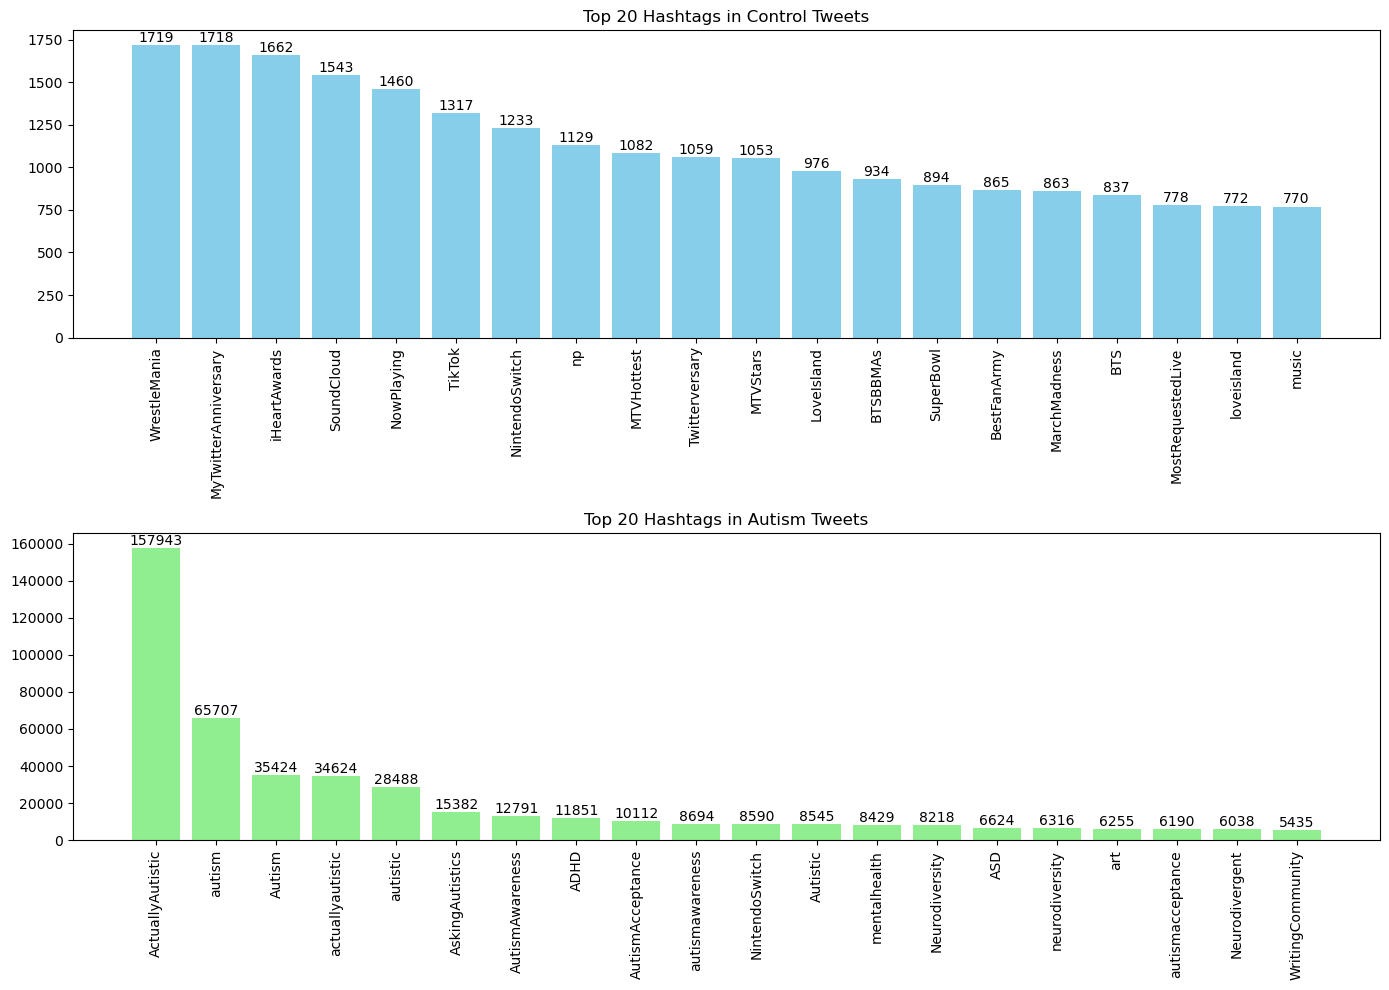

In [8]:
# Get the top 20 hashtags
top_20_control_hashtags = control_hashtag_freq.most_common(20)
top_20_autism_hashtags = autism_hashtag_freq.most_common(20)

# Plot the top 20 hashtags comparison
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

control_hashtags_df = pd.DataFrame(
    top_20_control_hashtags, columns=['Hashtag', 'Count'])
autism_hashtags_df = pd.DataFrame(
    top_20_autism_hashtags, columns=['Hashtag', 'Count'])

# Plot for Control Tweets
axs[0].bar(control_hashtags_df.index,
           control_hashtags_df['Count'], color='skyblue')
axs[0].set_title('Top 20 Hashtags in Control Tweets')
axs[0].set_xticks(control_hashtags_df.index)
axs[0].set_xticklabels(control_hashtags_df['Hashtag'], rotation=90)
for i, v in enumerate(control_hashtags_df['Count']):
    axs[0].text(i, v + 0.5, str(v), ha='center', va='bottom')

# Plot for Autism Tweets
axs[1].bar(autism_hashtags_df.index,
           autism_hashtags_df['Count'], color='lightgreen')
axs[1].set_title('Top 20 Hashtags in Autism Tweets')
axs[1].set_xticks(autism_hashtags_df.index)
axs[1].set_xticklabels(autism_hashtags_df['Hashtag'], rotation=90)
for i, v in enumerate(autism_hashtags_df['Count']):
    axs[1].text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### topic modelling on "Hashtags": add another column which store 1 for all strings are about autism; 0 for nothing about autism; 2 for both

In [9]:
# Define the list of autism-related hashtags
autism_related_hashtags = [
    'ActuallyAutistic', 'AskingAutistics', 'actuallyautistic', 'ADHD', 'autism', 'Neurodivergent', 'AuDHD', 'autistic', 'Autism', 
    'MentalHealth', 'AutisticTwitter','adhd', 'asd', 'aspie', 'MentalIllness', 'MentalHealthMatters','AutismAwareness', 'AutismAcceptance', 
    'autismawareness', 'Autistic','ASD', 'autismacceptance', 'Neurodivergent', 'aspergers', 'AllAutistics', 'neurodivergent',
    'DisabilityTwitter',  'depression','Aspergers', 'Disability',  'MentalHealthAwareness', 'autchat',
    'PTSD', 'neurodiversesquad', 'AutismAwarenessMonth', 'adhdtwitter', 'CPTSD', 'StopTheShock', 'Activate4Autism', 'awesomism'
]

# Function to determine the value of 'hashtag_top'
def determine_hashtag_top(hashtags):
    if not hashtags:
        return 0
    autism_tags = [tag for tag in hashtags if tag in autism_related_hashtags]
    if len(autism_tags) == len(hashtags):
        return 1
    elif len(autism_tags) == 0:
        return 0
    else:
        return 2


# Apply the function to create the 'hashtag_top' column
control_tweets_df['hashtag_top'] = control_tweets_df['Hashtags'].apply(
    determine_hashtag_top)
autism_tweets_df['hashtag_top'] = autism_tweets_df['Hashtags'].apply(
    determine_hashtag_top)

# Display the first few rows of the updated DataFrames
control_tweets_df.head(), autism_tweets_df.head()

(                                             User_ID  Friends count  \
 0  0aa837fd4fa1a7b5da1408f8288d3e20ad53fa95ffcbeb...            648   
 1  824a494eb5be73f7118ad421e80b829c4646cad458d233...            626   
 2  749acd73361c361cffb38c0767eb27a907a0d3bd9ec03d...           1816   
 3  2f8b0dfec60e7b93bd8a9d9573a365c19f5c89da7c04ec...            343   
 4  e31b4092e6a8e8f8d574b25f58c994a4daedccbdf5beb8...           3024   
 
    Followers count                 Tweet date             Tweet id  \
 0              299  2015-07-01 23:59:56+00:00   616395848411410432   
 1              617  2014-01-28 23:59:56+00:00   428316542674030592   
 2             5103  2020-07-03 23:59:49+00:00  1279203223539195904   
 3              162  2015-06-11 23:59:50+00:00   609148064817938432   
 4             5998  2018-03-20 23:59:36+00:00   976246914164428801   
 
                                           Tweet text        Hashtags  \
 0                         want 2 goal lady . lioness     [Liones

# Hypothesis_1 testing

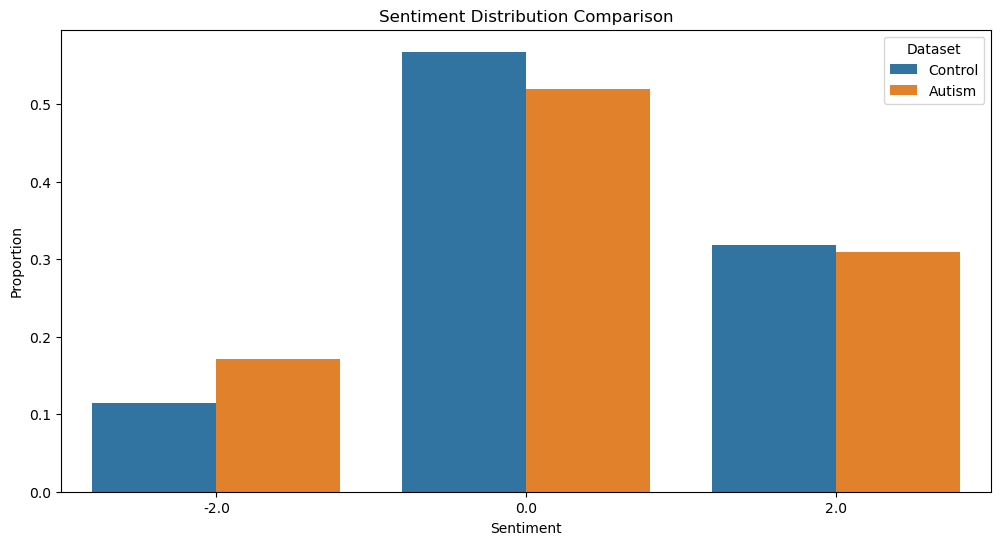

Chi-Square Test Results:
Chi2 Statistic: 13.951341241543084
P-value: 0.00745198465624079
The sentiment distributions between the two groups are significantly different.


In [10]:
# Extract sentiment distributions
control_sentiment_dist = control_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)
autism_sentiment_dist = autism_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)

# Combine sentiment distributions into a DataFrame for visualization
sentiment_dist_df = pd.DataFrame({
    'Sentiment': control_sentiment_dist.index,
    'Control': control_sentiment_dist.values,
    'Autism': autism_sentiment_dist.reindex(control_sentiment_dist.index).fillna(0).values
}).melt(id_vars='Sentiment', var_name='Dataset', value_name='Proportion')

# Visualize sentiment distributions
plt.figure(figsize=(12, 6))
sns.barplot(x='Sentiment', y='Proportion',
            hue='Dataset', data=sentiment_dist_df)
plt.title('Sentiment Distribution Comparison')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.show()

# Statistical test: Chi-Square test of independence
contingency_table = pd.crosstab(
    control_tweets_df['Tweet Text Sentiment'], autism_tweets_df['Tweet Text Sentiment'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-Square Test Results:\nChi2 Statistic: {chi2}\nP-value: {p}")

# Interpretation based on p-value
if p < 0.05:
    print("The sentiment distributions between the two groups are significantly different.")
else:
    print("There is no significant difference in the sentiment distributions between the two groups.")

# save the final files for network, user-interaction network

In [11]:
# Ensure counts are integers and handle NaNs
control_tweets_df['Reply count'] = control_tweets_df['Reply count'].fillna(0).astype(int)
control_tweets_df['Retweet count'] = control_tweets_df['Retweet count'].fillna(0).astype(int)
control_tweets_df['Like count'] = control_tweets_df['Like count'].fillna(0).astype(int)

autism_tweets_df['Reply count'] = autism_tweets_df['Reply count'].fillna(0).astype(int)
autism_tweets_df['Retweet count'] = autism_tweets_df['Retweet count'].fillna(0).astype(int)
autism_tweets_df['Like count'] = autism_tweets_df['Like count'].fillna(0).astype(int)

In [12]:
control_tweets_df = control_tweets_df.drop(columns=['Tweet text'])      
autism_tweets_df = autism_tweets_df.drop(columns=['Tweet text'])
control_tweets_df.head()
autism_tweets_df.head()

,User_ID,Friends count,Followers count,Tweet date,Tweet id,Hashtags,Location,Reply count,Retweet count,Like count,Tweet Text Sentiment,hashtag_top
0,4d40ced1122d03ff51565e460723aa88cf10da83a47872...,152,361,2022-12-31 23:01:30+00:00,1609323893193318401,[ActuallyAutistic],Picnic Party,0,0,3,2,1
1,60f8e994a389fc65557cdf594582e5764fab50766cd13b...,1756,2868,2022-12-31 21:42:00+00:00,1609303887030243330,"[HappyNewYear, Trekkies, Whovians, ActuallyAut...",NaN,6,4,41,2,2
2,975f72be21fc87c6701385533e6e25c789a84e0f4074b8...,1278,280,2022-12-31 20:20:12+00:00,1609283300857909250,"[ActuallyAutistic, ADHD]",NaN,0,0,0,2,1
3,a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...,771,752,2022-12-31 20:15:30+00:00,1609282116965257219,"[helpfolkslive2022, mutualaidrequest, actually...",NaN,0,35,24,0,2
4,60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...,3692,1733,2022-12-31 20:13:32+00:00,1609281620657467398,"[EmergencyCrowdFund, TwitterPhilanthropy, Disa...",https://ko-fi.com/thechasms,2,7,4,0,2


In [13]:
# Function to parse the Hashtags column
def parse_hashtags(hashtags):
    try:
        return ast.literal_eval(hashtags)
    except (ValueError, SyntaxError):
        return []

# Apply the function to ensure Hashtags column is parsed correctly
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].apply(parse_hashtags)
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].apply(parse_hashtags)

In [14]:
# Function to create a User Interaction Network
def create_user_interaction_network(df):
    G = nx.Graph()
    for index, row in df.iterrows():
        user = row['User_ID']
        G.add_node(user)
        if row['Reply count'] > 0:
            G.add_edge(user, f"Reply_{row['Tweet id']}")
        if row['Retweet count'] > 0:
            G.add_edge(user, f"Retweet_{row['Tweet id']}")
        if row['Like count'] > 0:
            G.add_edge(user, f"Like_{row['Tweet id']}")
    return G


In [15]:
# Create User Interaction Networks for both datasets
control_user_network = create_user_interaction_network(control_tweets_df)
autism_user_network = create_user_interaction_network(autism_tweets_df)

In [16]:
# Filter networks to include nodes with degree > 0
def filter_network_by_degree(G):
    G_filtered = G.copy()
    for node in list(G.nodes):
        if G.degree(node) == 0:
            G_filtered.remove_node(node)
    return G_filtered


control_user_network_filtered = filter_network_by_degree(control_user_network)
autism_user_network_filtered = filter_network_by_degree(autism_user_network)

In [17]:
# Save matched rows for the networks
control_user_network_nodes = list(control_user_network_filtered.nodes)
autism_user_network_nodes = list(autism_user_network_filtered.nodes)

control_user_network_df = control_tweets_df[control_tweets_df['User_ID'].isin(control_user_network_nodes)]
autism_user_network_df = autism_tweets_df[autism_tweets_df['User_ID'].isin(autism_user_network_nodes)]


In [18]:
# Save files with tqdm progress bar
with tqdm(total=2, desc="Saving files") as pbar:
    control_user_network_df.to_csv(
        'dataset/control_user_network_matched_rows.csv', index=False)
    pbar.update(1)
    autism_user_network_df.to_csv(
        'dataset/autism_user_network_matched_rows.csv', index=False)
    pbar.update(1)

Saving files: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
